# Get Data

In [1]:
import numpy as np
import pandas as pd
from helper import *

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('data/train.csv')
df['Id'] = df['Id'].astype('int32')

In [4]:
df.shape

(1460, 81)

In [5]:
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,

In [6]:
X = df.drop(columns=['SalePrice'])
X.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,205,G

In [7]:
y = df['SalePrice']
y.head(10)

0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

# Graph Data

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

def plot_columns_against_target(columns, target, data):
    """
    Plots the values of the specified columns against the target variable.

    Parameters:
    - columns: list of column names to plot
    - target: target variable (e.g., y)
    - data: DataFrame containing the columns and target

    Returns:
    - None
    """
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=data[column], y=target)
        plt.title(f'{column} vs Target')
        plt.xlabel(column)
        plt.ylabel('Target')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
plot_columns_against_target(X.columns, y, df)

# Cleaning


In [8]:
X.isna().sum()[X.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [9]:
cleaning = CleaningPreprocessor()
cleaning.fit(X, y)

CleaningPreprocessor()

In [10]:
cleaned_X = cleaning.transform(X)
cleaned_X.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GarageYrBltInt
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,2000-2019
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,1960-1979
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,2000-2019
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,1980-1999
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,2000-2019
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,1980-1999
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,2000-2019
7,8,60,RL,69.0,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,1960-1979
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,1920-1939
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y

In [11]:
cleaned_X.isna().sum()[cleaned_X.isna().sum() > 0]

Series([], dtype: int64)

# Feature Engineering


In [12]:
cat_cols = cleaned_X.select_dtypes(include=['object']).columns
check_columns(cleaned_X)

Categorical columns: 45
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBltInt'],
      dtype='object')
Numerical columns: 35
Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath',

In [13]:
label_encoding = FeatureEngineeringPreprocessor()
label_encoding.fit(cleaned_X, y)
target_encoding = FeatureEngineeringPreprocessor(target_cats=cat_cols)
target_encoding.fit(cleaned_X, y)
frequency_encoding = FeatureEngineeringPreprocessor(frequency_cats=cat_cols)
frequency_encoding.fit(cleaned_X, y)
onehot_encoding = FeatureEngineeringPreprocessor(one_hot_cats=cat_cols)
onehot_encoding.fit(cleaned_X, y)

FeatureEngineeringPreprocessor(one_hot_cats=Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBltInt'],
      dtype='object'))

In [14]:
engineered_X = target_encoding.transform(cleaned_X)
engineered_X.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GarageYrBltInt
0,1,239948.501672,191004.994787,65.0,8450,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,7,5,2003,2003,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,196.0,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,165652.295908,235413.720096,706,184694.690287,0,150,856,182021.195378,214914.429150,186186.70989,186810.637453,856,854,0,1710,1,0,2,1,3,1,212116.023891,8,183429.147059,0,141331.482609,202892.656322,202068.869668,2,548,187489.836003,187885.735294,186433.973881,0,61,0,0,0,0,180404.663455,187596.837998,182046.410384,0,2,2008,173401.836622,175202.219533,239049.925373
1,2,185224.811567,191004.994787,80.0,9600,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,177934.574468,179956.799566,238772.727273,142475.481481,181169.405536,185763.807377,175985.477961,6,8,1976,1976,171483.956179,179803.679219,149422.177273,149803.172897,156958.243119,0.0,144341.313466,184034.896256,149805.714511,202688.478964,183632.620900,257689.805970,161573.068182,978,184694.690287,0,284,1262,182021.195378,214914.429150,186186.70989,186810.637453,1262,0,0,1262,0,1,2,0,3,1,139962.511565,6,183429.147059,1,205723.488818,202892.656322,202068.869668,2,460,187489.836003,187885.735294,186433.973881,298,0,0,0,0,0,180404.663455,187596.837998,182046.410384,0,5,2007,173401.836622,175202.219533,153275.097035
2,3,239948.501672,191004.994787,68.0,11250,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,7,5,2001,2002,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,162.0,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,192789.657895,235413.720096,486,184694.690287,0,434,920,182021.195378,214914.429150,186186.70989,186810.637453,920,866,0,1786,1,0,2,1,3,1,212116.023891,6,183429.147059,1,205723.488818,202892.656322,202068.869668,2,608,187489.836003,187885.735294,186433.973881,0,42,0,0,0,0,180404.663455,187596.837998,182046.410384,0,9,2008,173401.836622,175202.219533,239049.925373
3,4,166772.416667,191004.994787,60.0,9550,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,181623.425856,179956.799566,210624.725490,184495.492063,181169.405536,185763.807377,210051.764045,7,5,1915,1970,171483.956179,179803.679219,149841.645631,161328.947368,156958.243119,0.0,144341.313466,184034.896256,132291.075342,140759.818182,213599.907692,165652.295908,161573.068182,216,184694.690287,0,540,756,182021.195378,156858.871369,186186.70989,186810.637453,961,756,0,1717,1,0,1,0,3,1,212116.023891,7,183429.147059,1,226351.415789,134091.162791,142156.423140,3,642,187489.836003,187885.735294,186433.973881,0,35,272,0,0,0,180404.663455,187596.837998,182046.410384,0,2,2006,173401.836622,146526.623762,201763.199313
4,5,239948.501672,191004.994787,84.0,14260,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,177934.574468,179956.799566,335295.317073,184495.492063,181169.405536,185763.807377,210051.764045,8

# Feature Selection


In [15]:
selecting = ExtensiveFeatureSelectionPreprocessor()
selecting.fit(engineered_X, y)

ExtensiveFeatureSelectionPreprocessor()

In [16]:
filtered_X = selecting.transform(engineered_X)
filtered_X.head(10)

,Id,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars
0,1,7,5,1,0,2,1,3,1,0,2
1,2,6,8,0,1,2,0,3,1,1,2
2,3,7,5,1,0,2,1,3,1,1,2
3,4,7,5,1,0,1,0,3,1,1,3
4,5,8,5,1,0,2,1,4,1,1,3
5,6,5,5,1,0,1,1,1,1,0,2
6,7,8,5,1,0,2,0,3,1,1,2
7,8,7,6,1,0,2,1,3,1,2,2
8,9,7,5,0,0,2,0,2,2,2,2
9,10,5,6,1,0,1,0,2,2,2,1


# Training

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import warnings
from sklearn.exceptions import ConvergenceWarning

## Parameters

In [ ]:
cat_cols = cleaned_X.select_dtypes(include=['object']).columns
cat_cols

In [18]:
target_encoded_cols = []
frequency_encoded_cols = []
onehot_encoded_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBltInt']

corr_threshold = 0.8
rfe_n_features = 30

In [ ]:
target_encoded_cols = []
frequency_encoded_cols = []
onehot_encoded_cols = []

corr_threshold = 0.8
rfe_n_features = 30

## Prepare Preprocessors

In [19]:
cleaning = CleaningPreprocessor()
cleaned_X = cleaning.fit_transform(X, y)

engineering = FeatureEngineeringPreprocessor(
    one_hot_cats=onehot_encoded_cols,
    target_cats=target_encoded_cols,
    frequency_cats=frequency_encoded_cols
)
engineered_X = engineering.fit_transform(cleaned_X, y)

to_drop = correlation_filter(engineered_X, y, corr_threshold, log=True)
dropped_X = engineered_X.drop(columns=to_drop)
to_stay = rfe(dropped_X, y, rfe_n_features, log=True)

selecting = FeatureSelectionPreprocessor(selected_features=to_stay)
selected_X = selecting.fit_transform(dropped_X, y)

selected_X.head(10)

Highly correlated pairs:
1stFlrSF and TotalBsmtSF: 0.8195299750050339
TotRmsAbvGrd and GrLivArea: 0.8254893743088425
GarageArea and GarageCars: 0.882475414281462
MSZoning_RM and MSZoning_RL: 0.8085853546363103
Neighborhood_Somerst and MSZoning_FV: 0.8628071099772279
BldgType_2fmCon and MSSubClass_190: 0.9833947289220359
BldgType_Duplex and MSSubClass_90: 1.0
HouseStyle_1.5Unf and MSSubClass_45: 0.9251805003181278
HouseStyle_2Story and 2ndFlrSF: 0.8091497798648831
HouseStyle_SLvl and MSSubClass_80: 0.9422592628254366
RoofStyle_Hip and RoofStyle_Gable: 0.9334615823692307
Exterior2nd_CBlock and Exterior1st_CBlock: 1.0
Exterior2nd_CmentBd and Exterior1st_CemntBd: 0.9741710841939724
Exterior2nd_HdBoard and Exterior1st_HdBoard: 0.883271397030471
Exterior2nd_MetalSd and Exterior1st_MetalSd: 0.9730651937625319
Exterior2nd_VinylSd and Exterior1st_VinylSd: 0.9775248873036357
Exterior2nd_Wd Sdng and Exterior1st_Wd Sdng: 0.8592439328330361
MasVnrType_None and MasVnrType_BrkFace: 0.8063369540930607

,Id,MSSubClass_180,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_StoneBr,Condition2_PosA,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_ImStucc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,Functional_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PoolQC_Fa,PoolQC_Gd,PoolQC_None,SaleType_Con
0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
1,2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
2,3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
3,4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False
4,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
5,6,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
6,7,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
7,8,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False
8,9,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False
9,10,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False


## Experiment

In [20]:
search_pipeline = Pipeline([
    ('cleaner', cleaning),
    ('engineer', engineering),
    ('selector', selecting),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    Normalizer(),
    None
]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = [
    {
        'scaler': scalers,
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]
    },
    {
        'scaler': scalers,
        'regressor': [Ridge(max_iter=10000), Lasso(max_iter=10000)],
        'regressor__alpha': [0.1, 1, 10]
    },
    {
        'scaler': scalers,
        'regressor': [ElasticNet(max_iter=10000)],
        'regressor__alpha': [0.1, 1, 10],
        'regressor__l1_ratio': [0.2, 0.5, 0.8]
    }
]

scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_median_absolute_error': 'neg_median_absolute_error',
    'r2': 'r2',
    'explained_variance': 'explained_variance'
}

grid_search = GridSearchCV(
    search_pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring=scoring,
    refit='neg_mean_squared_error',
    verbose=2,
    return_train_score=True
)

In [21]:
# Suppress convergence warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search.fit(X, y)

Fitting 5 folds for each of 85 candidates, totalling 425 fits
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=MinMaxScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=MinMaxScaler(); total time=   0.2s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, scaler=MinMaxScaler(); total time=   0.2s
[CV] END regressor=LinearRegress

In [ ]:
grid_search_results(grid_search)

# Graph Best Results

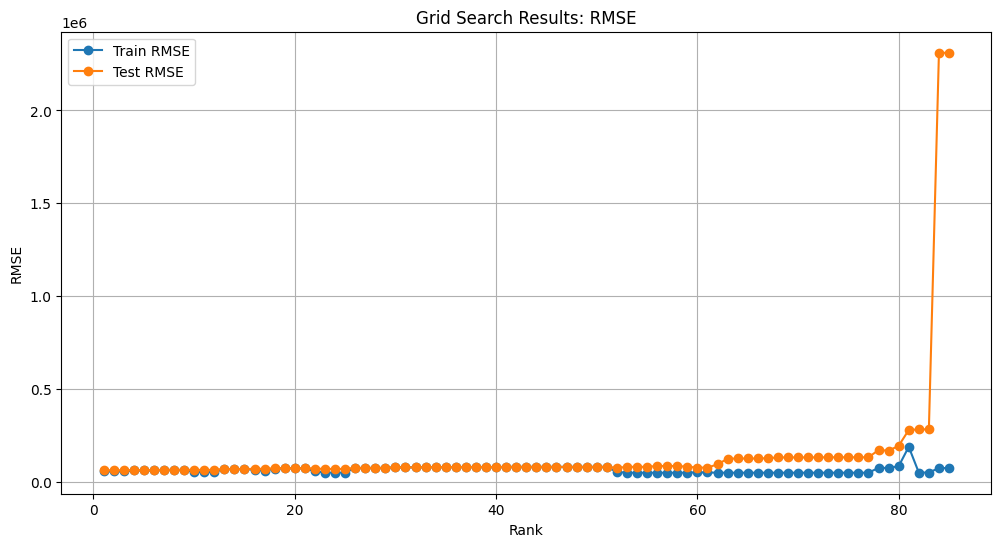

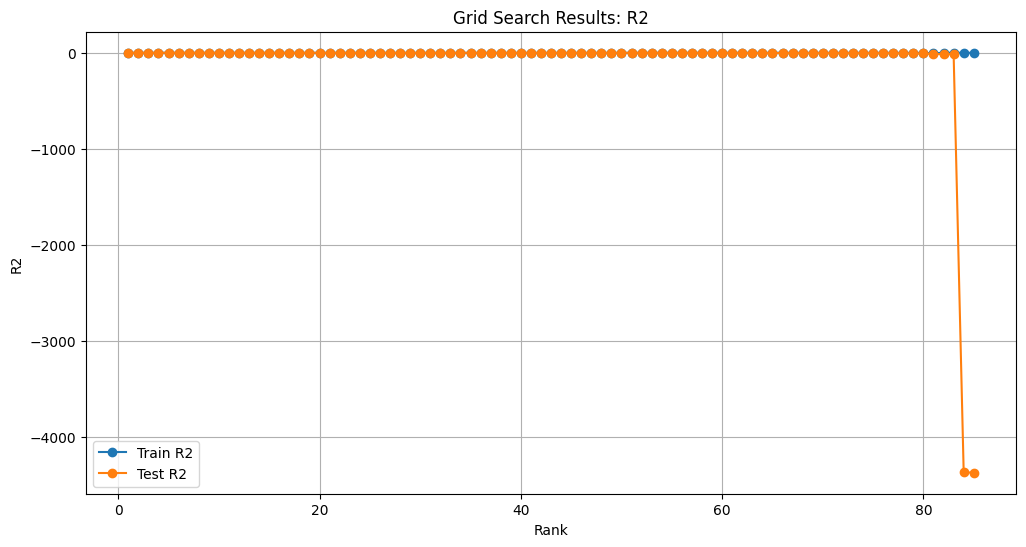

In [23]:
plot_grid_search_results(grid_search)

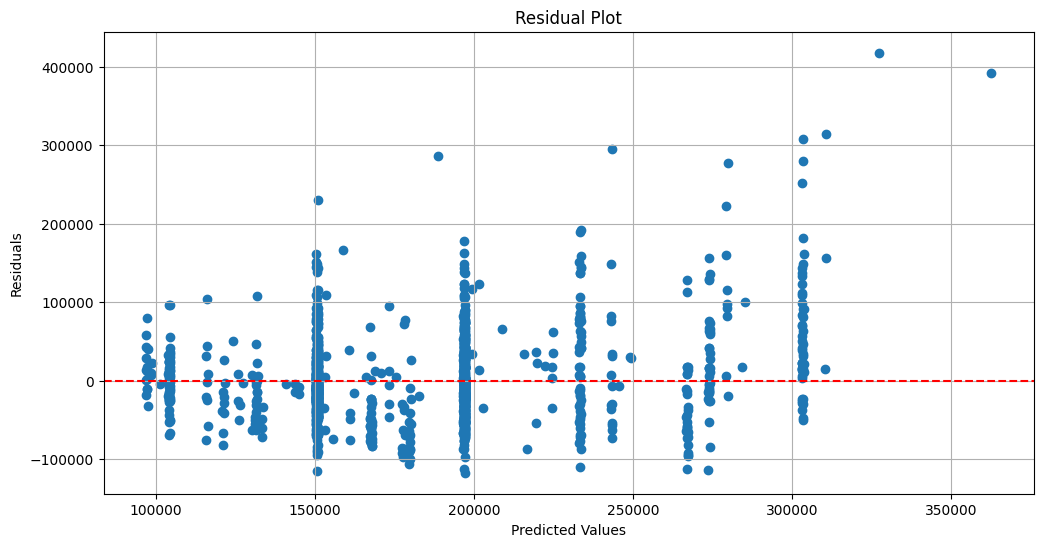

In [22]:
residual_plot(grid_search.best_estimator_, X, y)

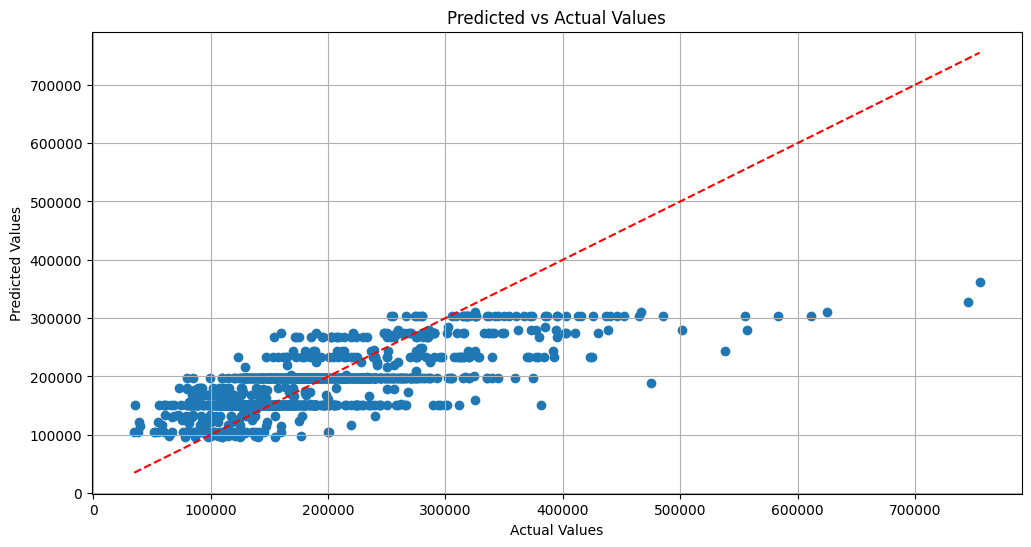

In [24]:
predicted_vs_actual_plot(grid_search.best_estimator_, X, y)

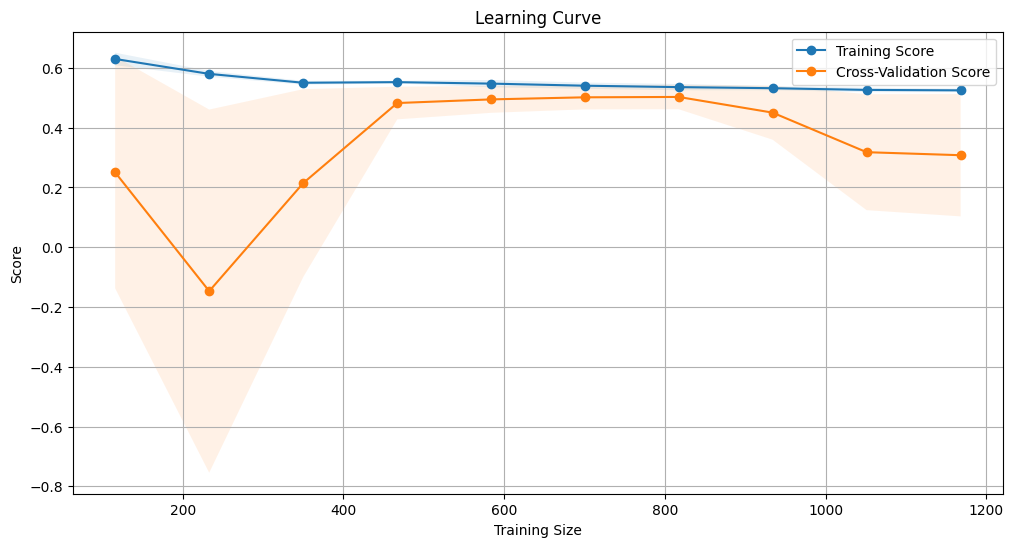

In [25]:
learning_curve_plot(grid_search.best_estimator_, X, y)

# Single Pipeline

In [28]:
single_pipeline = Pipeline([
    ('cleaner', cleaning),
    ('engineer', engineering),
    ('selector', selecting),
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet(max_iter=10000, alpha=0.1, l1_ratio=0.2))
])

single_pipeline.fit(X, y)
test = pd.read_csv('data/test.csv')
pred = single_pipeline.predict(test)

## Graph Single Pipeline Results

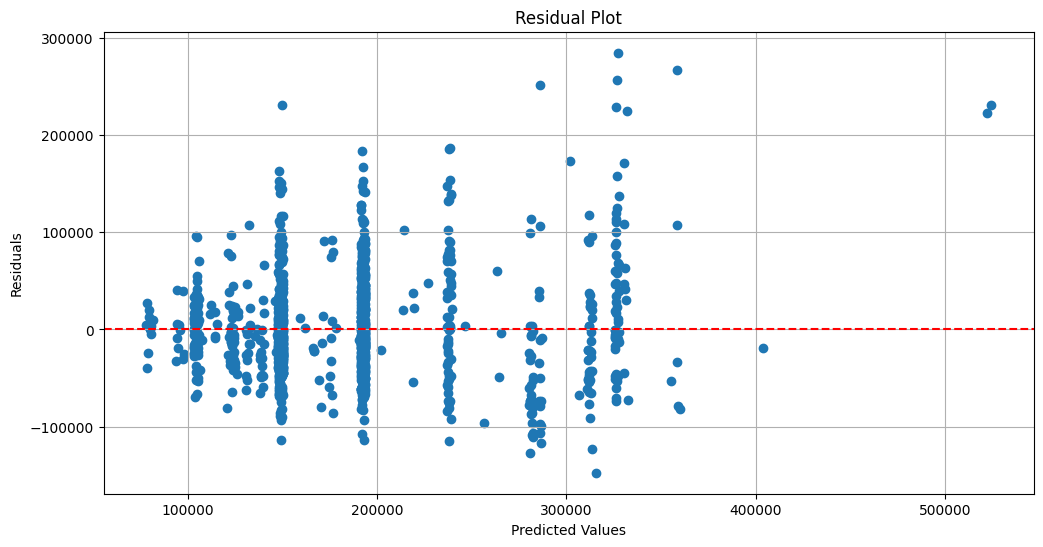

In [29]:
residual_plot(single_pipeline, X, y)

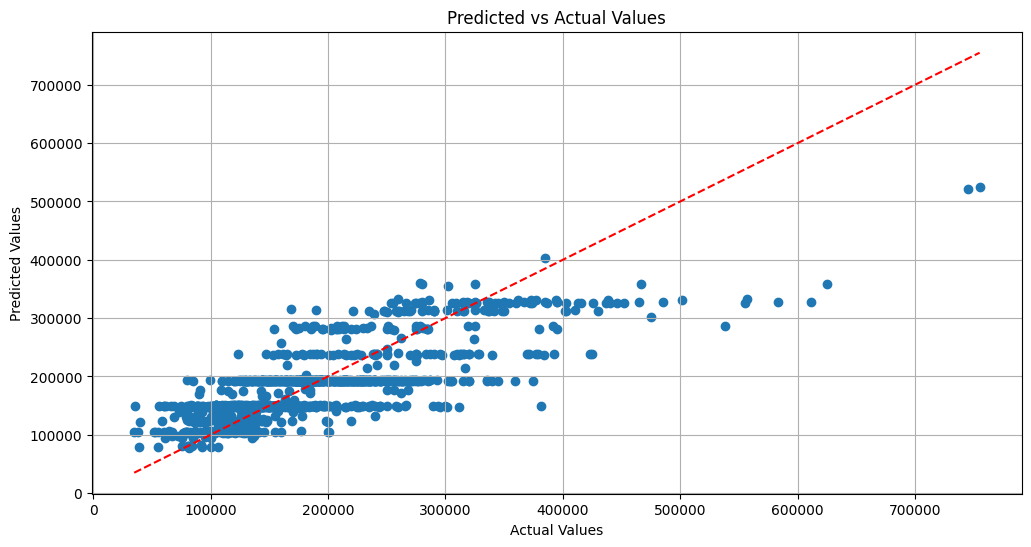

In [30]:
predicted_vs_actual_plot(single_pipeline, X, y)

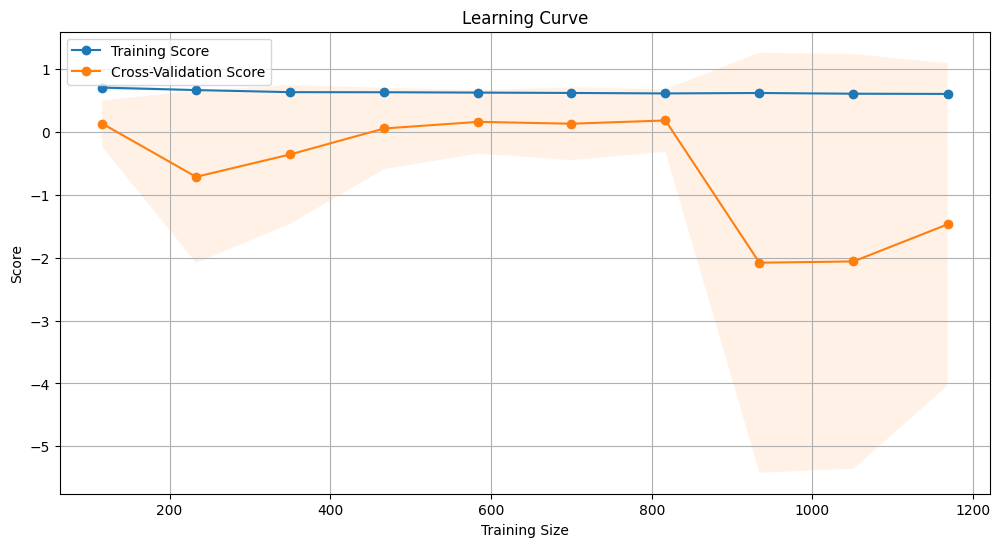

In [31]:
learning_curve_plot(single_pipeline, X, y)

# Dagshub Upload

In [ ]:
import dagshub
import mlflow
from mlflow.models.signature import infer_signature
dagshub.init(repo_owner='Cimbir', repo_name='advanced-regression-techniques', mlflow=True)

In [ ]:
result = grid_search_results(grid_search)

name = 'all_OHE'

mlflow.set_experiment(f'{name}_experiment')

for i, row in result.iterrows():
    if row['Rank'] >= 5 and row['Rank'] < len(result) - 5:
        continue
    with mlflow.start_run(run_name=f'{name}_{i}') as run:
        run_id = run.info.run_id
        mlflow.log_param(f"target_encoded", str(target_encoded_cols))
        mlflow.log_param(f"frequency_encoded", str(frequency_encoded_cols))
        mlflow.log_param(f"onehot_encoded", str(onehot_encoded_cols))
        mlflow.log_param(f"corr_threshold", str(corr_threshold))
        mlflow.log_param(f"rfe_n_features", str(rfe_n_features))
        mlflow.log_param(f"selected_features", str(to_stay))
        
        mlflow.log_param(f"scaler", str(row['params']['scaler']))
        mlflow.log_param(f"regressor", str(row['params']['regressor']))
        mlflow.log_param(f"regressor__fit_intercept", str(row['params'].get('regressor__fit_intercept', None)))
        mlflow.log_param(f"regressor__alpha", str(row['params'].get('regressor__alpha', None)))
        mlflow.log_param(f"regressor__max_iter", str(row['params'].get('regressor__max_iter', None)))
        mlflow.log_param(f"regressor__l1_ratio", str(row['params'].get('regressor__l1_ratio', None)))
        
        mlflow.log_metric("MSE_test", row['MSE_test'])
        mlflow.log_metric("RMSE_test", row['RMSE_test'])
        mlflow.log_metric("MAE_test", row['MAE_test'])
        mlflow.log_metric("MedAE_test", row['MedAE_test'])
        mlflow.log_metric("R2_test", row['R2_test'])
        mlflow.log_metric("EV_test", row['EV_test'])
        mlflow.log_metric("MSE_train", row['MSE_train'])
        mlflow.log_metric("RMSE_train", row['RMSE_train'])
        mlflow.log_metric("MAE_train", row['MAE_train'])
        mlflow.log_metric("MedAE_train", row['MedAE_train'])
        mlflow.log_metric("R2_train", row['R2_train'])
        mlflow.log_metric("EV_train", row['EV_train'])
        mlflow.log_metric("Rank", row['Rank'])
        
        if(row['Rank'] == 1):
            mlflow.sklearn.log_model(
                grid_search.best_estimator_,
                artifact_path='model',
                registered_model_name=f'{name}_best'
            )
            

        print(f"Logged {i} to MLflow")